In [8]:
import numpy as np
import pandas as pd
import os
import sys
import mne
np.random.seed(123456789)
sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.io.patient.subject import Subject
from tvbsim.io.simdata.loadtvbdata import StructuralDataLoader
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

from tvbsim.exp.master import MasterExp

from tvbsim.visualize.old import plotts
from tvbsim.execute.cluster.hpc_tvbsimmodel import TVBSimModel

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config() 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext line_profiler
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in Structural Datasets Needed For TVB

- Define helper functions if we want to customize our simulations
- load in structural data using a data loader that we have written

In [9]:
def select_ez_outside(conn, clinezregions, numsamps):
    from tvbsim.exp.utils.selectregion import Regions
    # region selector for out of clinical EZ simulations
    epsilon = 60 # the mm radius for each region to exclude other regions
    regionselector = Regions(conn.region_labels, conn.centres, epsilon)
    # the set of regions that are outside what clinicians labeled EZ
    outside_set = regionselector.generate_outsideset(clinezregions)
    # sample it for a list of EZ regions
    osr_list = regionselector.sample_outsideset(outside_set, numsamps)

    osr_inds = [ind for ind, reg in enumerate(conn.region_labels) if reg in osr_list]
    return osr_list, osr_inds

def select_ez_inside(conn, clinezregs, numsamps):
    inside_list = np.random.choice(clinezregs, size=min(len(clinezregs),numsamps), replace=False)
    inside_inds = [ind for ind, reg in enumerate(conn.region_labels) if reg in inside_list]
    return inside_list, inside_inds

In [10]:
patient = 'id001_bt'
root_dir = os.path.join('/Users/adam2392/Downloads/tngpipeline/', patient)
loader = StructuralDataLoader(root_dir = root_dir)

2018-06-25 12:05:51,363 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-25 12:05:51,363 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-25 12:05:51,369 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-25 12:05:51,369 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-25 12:05:51,374 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-25 12:05:51,412 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-

# Define Possible parameter settings for TVB

- Can perform parameter sweep over range of parameters
- define parameters in dictionaries as defined below for each part in the TVB pipeline, then pass those into a mastertvbexp object, to run simulation experiment.

In [12]:
iext_sweep = np.linspace(2.5,3.5,5)
eps1_sweep = np.linspace(-0.5,0.5,5)
print(iext_sweep)
print(eps1_sweep)

## OUTPUTFILE NAME ##
outputdatadir = '/Users/adam2392/Downloads/simexp/tt=0.08/'
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

[2.5  2.75 3.   3.25 3.5 ]
[-0.5  -0.25  0.    0.25  0.5 ]


In [13]:
sim_length = 60000
period = 1

for iext in iext_sweep:
    for eps1 in eps1_sweep:
        # if moving contact experiments, recompute the gain matrix here

        # get the ez/pz indices we want to use
        clinezinds = loader.ezinds
        clinpzinds = []
        clinezregions = list(loader.conn.region_labels[clinezinds])
        clinpzregions = []

        # if we are sampling regions outside our EZ
        numsamps = 2 # should be around 1-3?
        ezregs, ezinds = select_ez_inside(loader.conn, clinezregions, numsamps)
        # ezregs, ezinds = select_ez_outside(loader.conn, clinezregions, numsamps)

        ######## SET THE MODEL'S EZ AND PZ REGIONS ########
        modelezinds = ezinds
        modelpzinds = []
        modelezregions = ezregs
        modelpzregions = []

        # create connectivity object the way TVB wants it
        conn = connectivity.Connectivity.from_file(loader.connfile)
        conn_params = {
            'conn': conn,
            'condspeed': np.inf,
        }

        # initialize all parameters we want to set
        model_params = {
            'ezregions': modelezregions,
            'pzregions': modelpzregions,
            'x0ez': -1.6,
            'x0pz': -2.0,
            'r': 0.00037,              # Temporal scaling in the third state variable
            'Ks': -10,                 # Permittivity coupling, fast to slow time scale
            'tt': 0.08,                   # time scale of simulation
            'tau': 10,                   # Temporal scaling coefficient in fifth st var
            'x0norm': -2.45, # x0c value = -2.05
            'Iext': iext,
            'eps1': eps1,
        }

        ntau = 0
        noise_cov = np.array([0.001, 0.001, 0.,\
                                  0.0001, 0.0001, 0.])
        # define cov noise for the stochastic heun integrator
        integrator_params = {
            'dt': 0.05,
            'noisetype': 'additive',
            'ntau': ntau,
            'noise_cov': noise_cov,
        }

        # load couping
        coupling_params = {
            'a': 1.,
            'type_cpl': 'diff',
        }

         # load monitors
        initcond = None
        monitor_params = {
            'period': period,
            'moved': False,
            'initcond': initcond,
            'gainmat': loader.gainmat,
            'chanxyz': loader.chanxyz,
            'chanlabels': loader.chanxyzlabels
        }

        # SET UP SIMULATION
        masterexp = MasterExp(conn_params,
                                coupling_params,
                                model_params,
                                integrator_params,
                                monitor_params)
        masterexp.setupsim()
        allindices = masterexp.allindices
        
        
        # create output data
        i = "{}_{}".format(iext, eps1)
        outputfilename = os.path.join(outputdatadir,
                    '{}_{}.npz'.format(patient, i))
        metafilename = os.path.join(outputdatadir,
                    '{}_{}.json'.format(patient, i))

        print(metafilename)
        print(outputfilename)

        times, simvars, seegts = masterexp.runsim(sim_length=sim_length)

        postprocessor = PostProcessor(samplerate=1000, allszindices=allindices)
        secstoreject = 15
        times, epits, seegts, zts, statevars_dict = postprocessor.postprocts(simvars, seegts, times, secstoreject=secstoreject)

        # GET ONSET/OFFSET OF SEIZURE
        detector = DetectShift()
        settimes = detector.getonsetsoffsets(epits, allindices)
        seizonsets, seizoffsets = detector.getseiztimes(settimes)
        print("The detected onset/offsets are: {}".format(zip(seizonsets,seizoffsets)))

        # SET METADATA
        metadata = masterexp.get_metadata()
        metadata['onsetind'] = seizonsets
        metadata['offsetind'] = seizoffsets
        # metadata['modelezregs'] = modelezregions
        # metadata['modelezinds'] = modelezinds
        # metadata['modelpzregs'] = modelpzregions
        # metadata['modelpzinds'] = modelpzinds
        metadata['clinezregs'] = clinezregions
        metadata['clinpzregs'] = clinpzregions
        metadata['samplerate'] = 1000
        metadata['simfilename'] = outputfilename

        print(metadata.keys())

        # SAVE DATA
        loader._writejsonfile(metadata, metafilename)
        np.savez_compressed(outputfilename, epits=epits, seegts=seegts, 
                            zts=zts, statevars_dict=statevars_dict)

WARNING  File 'hemispheres' not found in ZIP.
/Users/adam2392/Downloads/simexp/tt=0.08/id001_bt_2.5_-0.5.json
/Users/adam2392/Downloads/simexp/tt=0.08/id001_bt_2.5_-0.5.npz
no onset/offset available!
The detected onset/offsets are: [(0, 0)]
['gainmat', 'x0norm', 'x0pz', 'conn_params', 'offsetind', 'clinpzregs', 'onsetind', 'monitor_params', 'ezregs', 'pzindices', 'pzregs', 'samplerate', 'ezindices', 'chanlabels', 'integrator_params', 'clinezregs', 'regions_centers', 'regions', 'model_params', 'chanxyz', 'x0ez', 'simfilename', 'coupling_params']
WARNING  File 'hemispheres' not found in ZIP.
/Users/adam2392/Downloads/simexp/tt=0.08/id001_bt_2.5_-0.25.json
/Users/adam2392/Downloads/simexp/tt=0.08/id001_bt_2.5_-0.25.npz
no onset/offset available!
The detected onset/offsets are: [(0, 0)]
['gainmat', 'x0norm', 'x0pz', 'conn_params', 'offsetind', 'clinpzregs', 'onsetind', 'monitor_params', 'ezregs', 'pzindices', 'pzregs', 'samplerate', 'ezindices', 'chanlabels', 'integrator_params', 'clinezre

In [7]:
print(metafilename)
print(os.path.exists(metafilename))

/Users/adam2392/Downloads/simexp/id001_bt_3.5_0.5.json
True


# Run Simulation

In [12]:
times, simvars, seegts = masterexp.runsim(sim_length=sim_length)

postprocessor = PostProcessor(samplerate=1000, allszindices=allindices)
secstoreject = 5
times, epits, seegts, zts, statevars_dict = postprocessor.postprocts(simvars, seegts, times, secstoreject=secstoreject)

# GET ONSET/OFFSET OF SEIZURE
detector = DetectShift()
settimes = detector.getonsetsoffsets(epits, allindices)
seizonsets, seizoffsets = detector.getseiztimes(settimes)
print("The detected onset/offsets are: {}".format(zip(seizonsets,seizoffsets)))

# SET METADATA
metadata = masterexp.get_metadata()
metadata['onsetind'] = seizonsets
metadata['offsetind'] = seizoffsets
# metadata['modelezregs'] = modelezregions
# metadata['modelezinds'] = modelezinds
# metadata['modelpzregs'] = modelpzregions
# metadata['modelpzinds'] = modelpzinds
metadata['clinezregs'] = clinezregions
metadata['clinpzregs'] = clinpzregions
metadata['samplerate'] = 1000
metadata['simfilename'] = outputfilename

print(metadata.keys())

# SAVE DATA
loader._writejsonfile(metadata, metafilename)
np.savez_compressed(outputfilename, epits=epits, seegts=seegts, 
                    zts=zts, statevars_dict=statevars_dict)

['gainmat', 'x0norm', 'x0pz', 'conn_params', 'offsetind', 'clinpzregs', 'onsetind', 'monitor_params', 'ezregs', 'pzindices', 'pzregs', 'samplerate', 'ezindices', 'chanlabels', 'integrator_params', 'clinezregs', 'regions_centers', 'regions', 'model_params', 'chanxyz', 'x0ez', 'simfilename', 'coupling_params']


# Visualize and Check the Data

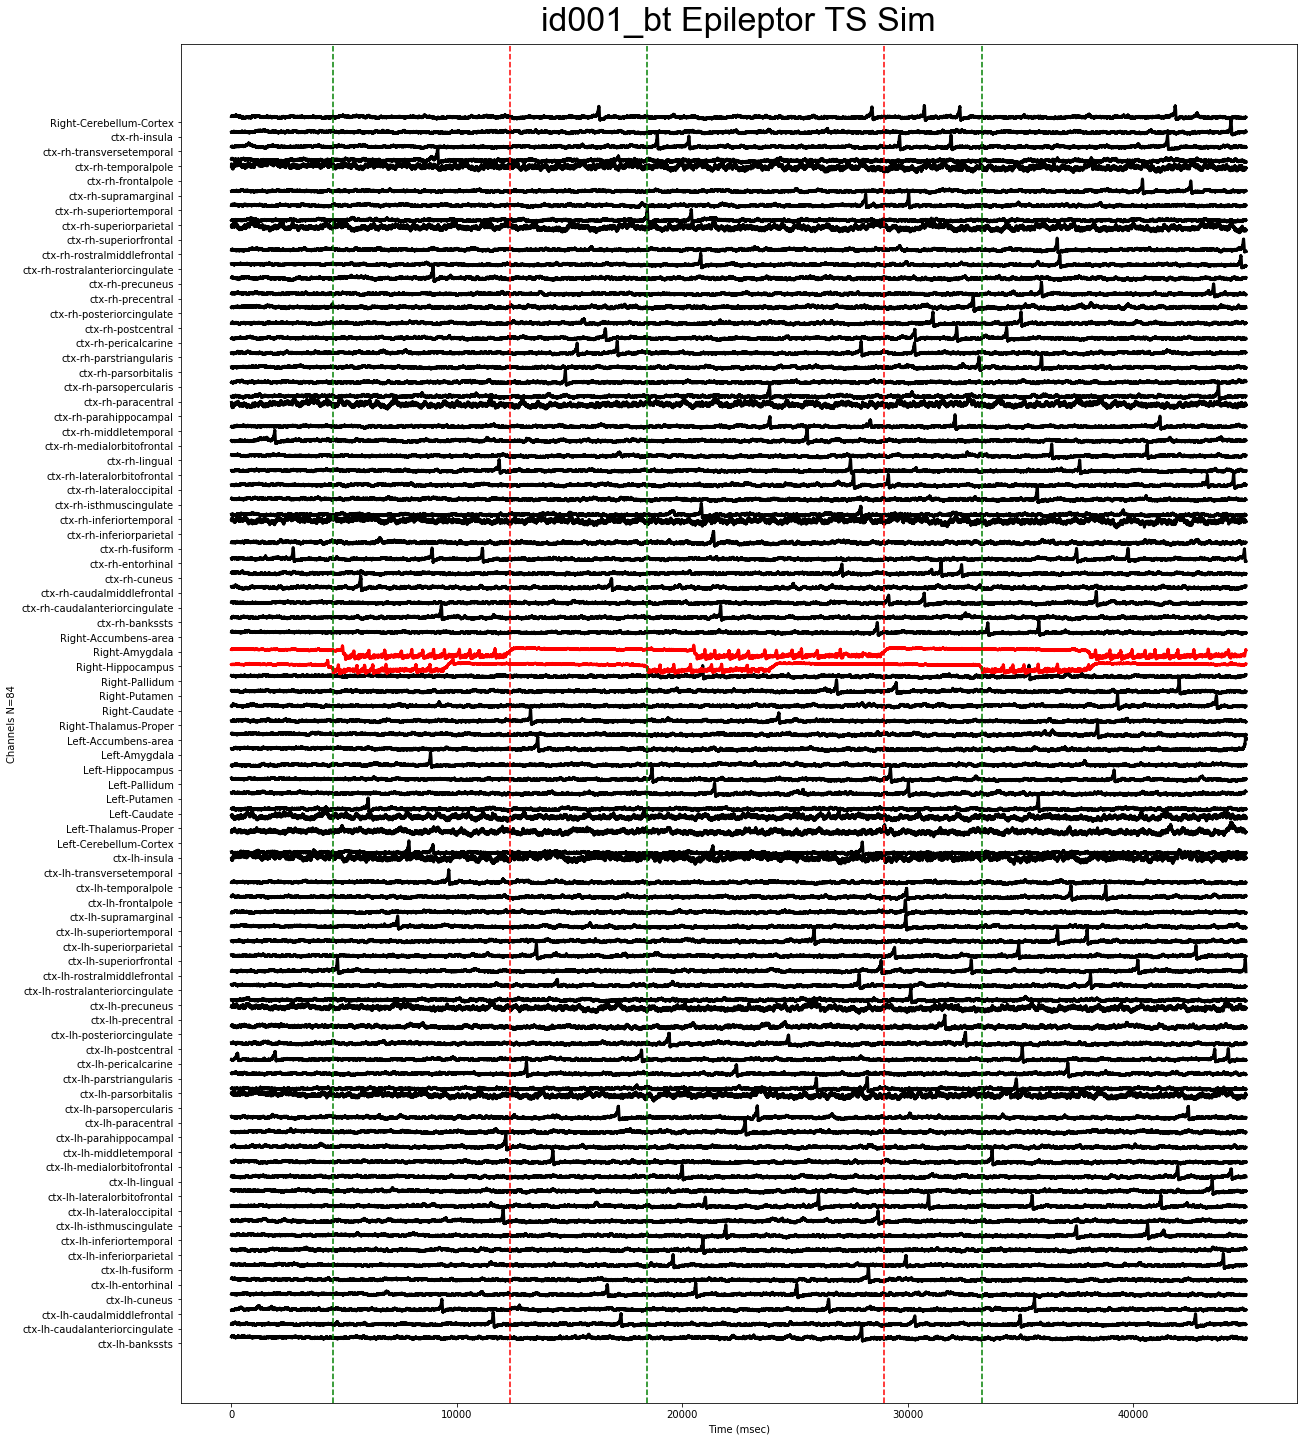

In [14]:
tsviz = tvbsim.visualize.old.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=conn.region_labels)
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} Epileptor TS Sim'.format(patient))
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(modelezinds, color='red')
tsviz.colorts(modelpzinds, color='blue')